# Peackage 导入

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from QubitHamiltonian import Transom_H, GQubitGCouplerGQubit


def forward_diff(f,x,dx = abs(0.001)):    
    """定义求导函数"""
    return((f(x+0.5*dx)-f(x-0.5*dx))/dx)

ModuleNotFoundError: No module named 'QubitHamiltonian'

# 单比特模拟

## 定义哈密顿量参数

In [4]:
C_q = 85e-15
R_j = 8500
# E_c=0.22*2*np.pi  #GHZ
# E_j=17*2*np.pi #GHZ

Transmon1 = Transom_H(C_q = C_q, R_j = R_j)

psi_0 = Transmon1.psi_0
psi_1 = Transmon1.psi_1
psi_2 = Transmon1.psi_2
rho_0=psi_0*psi_0.dag()
rho_1=psi_1*psi_1.dag()
rho_2=psi_2*psi_2.dag()

print(r'Qubit f_01 = ' + rf'{np.around(Transmon1.omega_01/2/np.pi,3)} GHz' )
print(r'Qubit f_ah = ' + rf'{np.around(Transmon1.anhar/2/np.pi,3)} GHz' )

Qubit f_01 = 5.25 GHz
Qubit f_ah = -0.254 GHz


## 在Gauss波包驱动下比特随时间演化

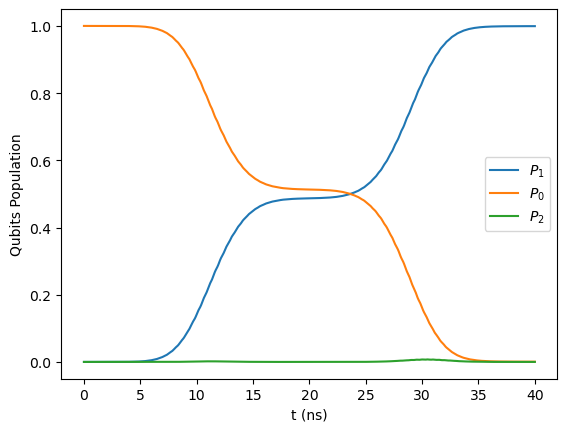

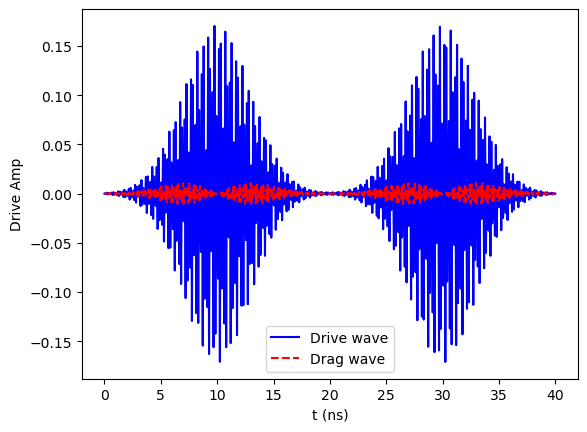

total run time is 2 s



In [5]:
starttime=int(time.time())

T_gate=20 #ns
t_nums=501
t_range=np.linspace(0,2*T_gate,t_nums)  #用两个pi/2门拼成一个pi门
drive_amp = 0.1715

H_t, drive_wave, drive_wave_drag = Transmon1.driveQ_gauss_H(drive_amp = drive_amp, 
                                                          omega_d = Transmon1.omega_01,T_gate = T_gate)
result=mesolve(H_t,psi_0,t_range,[] ,[rho_0,rho_1,rho_2])
P_0=result.expect[0]
P_1=result.expect[1]
P_2=result.expect[2]
plt.figure()
plt.plot(t_range,P_1, label = r'$P_1$')
plt.plot(t_range,P_0, label = r'$P_0$')
plt.plot(t_range,P_2, label = r'$P_2$')
plt.xlabel('t (ns)')
plt.ylabel('Qubits Population')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_range,[drive_wave(t_range[i])
                  for i in range(t_nums)],'b',label='Drive wave')
plt.plot(t_range,[drive_wave_drag(t_range[i])
                  for i in range(t_nums)],'r--',label='Drag wave')
plt.xlabel('t (ns)')
plt.ylabel('Drive Amp')
plt.legend()
plt.show()

endtime=int(time.time())
print('total run time is', endtime-starttime, 's\n')

## 在Cossin波包驱动下比特随时间演化

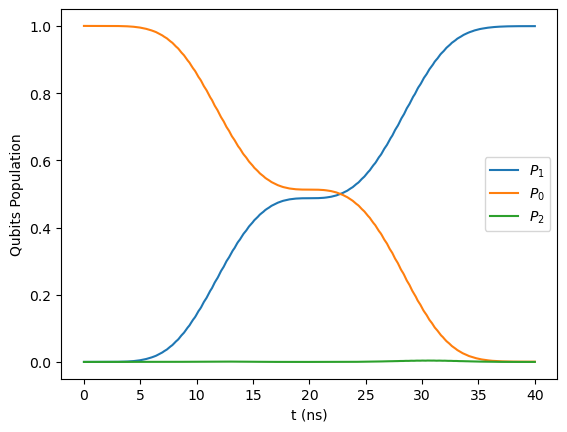

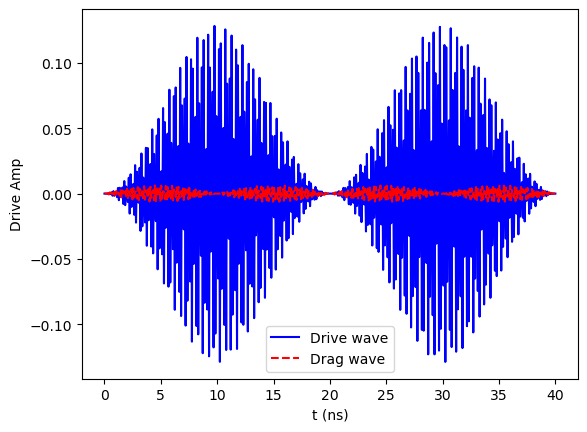

total run time is 1 s



In [6]:
starttime=int(time.time())

T_gate=20 #ns
t_nums=501
t_range=np.linspace(0,2*T_gate,t_nums) #用两个pi/2门拼成一个pi门
drive_amp = 0.1289

H_t, drive_wave, drive_wave_drag = Transmon1.driveQ_cos_H(drive_amp = drive_amp, induct_drive = False,
                                                          omega_d = Transmon1.omega_01,T_gate = T_gate)

result=mesolve(H_t,psi_0,t_range,[] ,[rho_0,rho_1,rho_2])
P_0=result.expect[0]
P_1=result.expect[1]
P_2=result.expect[2]
plt.figure()
plt.plot(t_range,P_1, label = r'$P_1$')
plt.plot(t_range,P_0, label = r'$P_0$')
plt.plot(t_range,P_2, label = r'$P_2$')
plt.xlabel('t (ns)')
plt.ylabel('Qubits Population')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_range,[drive_wave(t_range[i])
                  for i in range(t_nums)],'b',label='Drive wave')
plt.plot(t_range,[drive_wave_drag(t_range[i])
                  for i in range(t_nums)],'r--',label='Drag wave')
plt.xlabel('t (ns)')
plt.ylabel('Drive Amp')
plt.legend()
plt.show()

endtime=int(time.time())
print('total run time is', endtime-starttime, 's\n')

## （Rabi 2D 模拟） 固定时间下比特演化 VS 驱动频率&驱动幅值 Cossin波包 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   35.3s
[Parallel(n_jobs=12)]: Done  46 out of  51 | elapsed:  2.2min remaining:   14.0s
[Parallel(n_jobs=12)]: Done  51 out of  51 | elapsed:  2.5min finished


total run time is 149 s



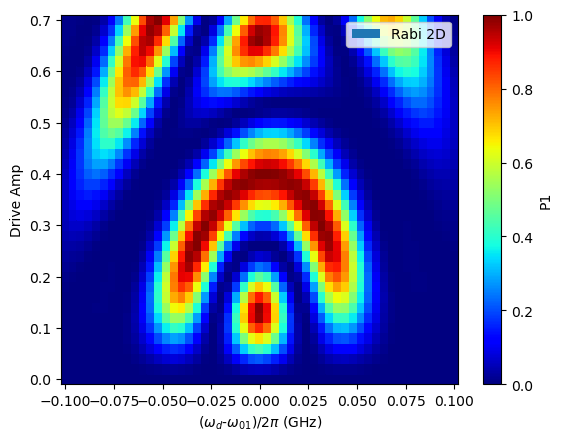

In [7]:
starttime=int(time.time())

T_gate=20 #ns
t_nums=501
t_range=np.linspace(0,2*T_gate,t_nums) #用两个pi/2门拼成一个pi门

Drive_amp_list=np.linspace(0,0.7,36)
F01_detune=np.linspace(-100e-3*2*np.pi,100e-3*2*np.pi,51)


P_0=[]
P_1=[]
P_2=[]

def multi_jobs_Rabi2D(k):

    P_0=[]
    P_1=[]
    P_2=[]
    omega_drive=Transmon1.omega_01+F01_detune[k]
    for i in range(len(Drive_amp_list)):
        drive_amp = Drive_amp_list[i]
        H_t = Transmon1.driveQ_cos_H(drive_amp = drive_amp, 
                                       omega_d = omega_drive,T_gate = T_gate)[0]
        result=mesolve(H_t,psi_0,t_range,[] ,[rho_0,rho_1,rho_2])
        P_0.append(result.expect[0][-1])
        P_1.append(result.expect[1][-1])
        P_2.append(result.expect[2][-1])
    return(P_0,P_1,P_2)

data = Parallel(n_jobs=12, verbose=3)(delayed(multi_jobs_Rabi2D)(k) for k in range(len(F01_detune)))
plt.figure()
X,Y=np.meshgrid(Drive_amp_list,F01_detune/2/np.pi)
plt.pcolor(Y,X,[data[i][1] for i in range(len(data) )],cmap='jet',label = 'Rabi 2D')
plt.clim(0,1)
plt.ylabel('Drive Amp')
plt.xlabel(r'($\omega_{d}$-$\omega_{01})/2\pi$ (GHz)')
plt.colorbar(label='P1')
plt.legend()


endtime=int(time.time())
print('total run time is', endtime-starttime, 's\n')

# 接地比特接地Coupler接地比特 系统

## 定义哈密顿量参数

In [7]:
e=1.6021766208e-19
h=6.626070154e-34
h_bar=h/2/np.pi
C_q1=78e-15
C_q2=78e-15
C_c=128e-15 #fF

C_qc1 = 10.5e-15 
C_qc2 = 10.5e-15
C_12 = 0.3e-15

EJ_c=26*2*np.pi
Rj_q1=9400
Rj_q2=9800
Rj_c = 1400
QCQ = GQubitGCouplerGQubit(
            C_q1 = C_q1, C_q2 = C_q2, C_c = C_c,
            C_qc1 = C_qc1, C_qc2 = C_qc2, C_12 = C_12,
            Rj_q1 = Rj_q1, Rj_q2 = Rj_q2, Rj_c = Rj_c,
            N_level = 8,)

## 计算比特频率等信息

In [8]:
phi_ex_q1 = 0
phi_ex_c = 0.0*np.pi
phi_ex_q2 = 0.0*np.pi
phi_ex_list = [phi_ex_q1,phi_ex_c,phi_ex_q2]
QCQsys_eigens = QCQ.QCQ_eigens(phi_ex_list)
QCQcouple_H = QCQ.Coupling_H(phi_ex_list)
H_sys = QCQcouple_H['H_total']
Eenergy_sub_list = QCQsys_eigens['Eenergy_sub_list']
Estate_sub_list = QCQsys_eigens['Estate_sub_list']
psi1_index_list = QCQsys_eigens['psi1_index_list']
psi1_tensor_list = QCQsys_eigens['psi1_tensor_list']
psi1_list = QCQsys_eigens['psi1_list']
E_energies = QCQsys_eigens['E_energies']
E_states = QCQsys_eigens['E_states']

index_q1 = 0
index_q2 = 2
index_c = 1
fre_q1_sub = [(Eenergy_sub_list[index_q1][i+1] - Eenergy_sub_list[index_q1][0])/2/np.pi
                 for i in range(len(Eenergy_sub_list[index_q1])-1)]
fre_c_sub = [(Eenergy_sub_list[index_c][i+1] - Eenergy_sub_list[index_c][0])/2/np.pi
                 for i in range(len(Eenergy_sub_list[index_c])-1)]
fre_q2_sub = [(Eenergy_sub_list[index_q2][i+1] - Eenergy_sub_list[index_q2][0])/2/np.pi
                 for i in range(len(Eenergy_sub_list[index_q2])-1)]
omega01_q1 = E_energies[psi1_index_list[index_q1]]- E_energies[0]
omega01_c = E_energies[psi1_index_list[index_c]]- E_energies[0]
omega01_q2 = E_energies[psi1_index_list[index_q2]]- E_energies[0]
omega_sys_list = [E_energies[i] - E_energies[0] for i in range(len(E_energies)-1)]

print(' f_q1_sub =', fre_q1_sub[0],'GHz\n f_q2_sub =',
      fre_q2_sub[0],'GHz\n f_c_sub =',fre_c_sub[0])
print(' f_q1 =', omega01_q1/2/np.pi,'GHz\n f_q2 =',
      omega01_q2/2/np.pi,'GHz\n f_c =',omega01_c/2/np.pi)
psi0_q1sub = Estate_sub_list[index_q1][0]
psi1_q1sub = Estate_sub_list[index_q1][1]
psi0_q2sub = Estate_sub_list[index_q2][0]
psi1_q2sub = Estate_sub_list[index_q2][1]
psi0_csub = Estate_sub_list[index_c][0]
psi1_csub = Estate_sub_list[index_c][1]

psi_000 = E_states[0]
psi_100 = E_states[psi1_index_list[index_q1]]
psi_010 = E_states[psi1_index_list[index_c]]
psi_001 = E_states[psi1_index_list[index_q2]]
g_qq = (psi1_tensor_list[index_q1]*psi1_tensor_list[index_q2].dag()*H_sys).tr()
g_qc1 = (psi1_tensor_list[index_q1]*psi1_tensor_list[index_c].dag()*H_sys).tr()
g_qc2 = (psi1_tensor_list[index_q2]*psi1_tensor_list[index_c].dag()*H_sys).tr()

print (' g_qq =', g_qq/2/np.pi,'GHz\n g_qc1=',
       g_qc1/2/np.pi,'GHz\n g_qc2=',g_qc2/2/np.pi,'GHz')
# print(g_qq**2/(omega01_q2-omega01_q1)/2/np.pi)
# print(g_qq**2/(omega01_q2-omega01_q1)**2)
psi0_q1 = (psi_000+psi_100).unit()
psi0_q2 = (psi_000+psi_001).unit()

 f_q1_sub = 4.896931918828603 GHz
 f_q2_sub = 4.790929727884199 GHz
 f_c_sub = 10.166384626593462
 f_q1 = 4.8705076481433105 GHz
 f_q2 = 4.765338539378881 GHz
 f_c = 10.19159489324051
 g_qq = -0.02859072932499091 GHz
 g_qc1= 0.3244251870053107 GHz
 g_qc2= -0.3208919785293072 GHz


## 计算等效耦合强度

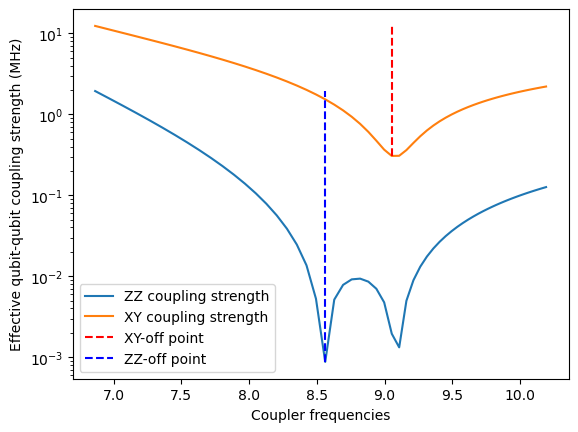

In [9]:
phi_ex_clist = np.linspace(np.pi*0.0,np.pi*0.35,71)
phi_ex_q1 = 0
phi_ex_q2 = 0

QCQ_geff = QCQ.Cal_geff(phi_ex_clist,
                        phi_ex_q1 = phi_ex_q1,
                        phi_ex_q2 = phi_ex_q2)
QCQ_eigens_list = QCQ_geff['QCQ_eigens_list']
g_xy_list = QCQ_geff['g_xy_list']
omega01_lists = QCQ_geff['omega01_lists']
g_zz_list = QCQ_geff['g_zz_list']

off_xy_index = QCQ_geff['off_xy_index']
off_zz_index = QCQ_geff['off_zz_index']
omega01c_off_xy = omega01_lists[off_xy_index][1]   #关断点的coupler频率

plt.figure()
plt.plot([o_list[1]/2/np.pi for o_list in omega01_lists],
          [abs(g)/1e-3/2/np.pi for g in g_zz_list], 
          label = 'ZZ coupling strength')
plt.plot([o_list[1]/2/np.pi for o_list in omega01_lists],
         [g/1e-3/2/np.pi for g in g_xy_list],
          label = 'XY coupling strength')
plt.plot([omega01_lists[off_xy_index][1]/2/np.pi, omega01_lists[off_xy_index][1]/2/np.pi],
         [np.min(g_xy_list)/1e-3/2/np.pi, np.max(g_xy_list)/1e-3/2/np.pi], 'r--',
         label = 'XY-off point')
plt.plot([omega01_lists[off_zz_index][1]/2/np.pi, omega01_lists[off_zz_index][1]/2/np.pi],
         [np.min(np.abs(g_zz_list))/1e-3/2/np.pi, np.max(np.abs(g_zz_list))/1e-3/2/np.pi], 'b--',
         label = 'ZZ-off point')
plt.xlabel('Coupler frequencies')
plt.ylabel('Effective qubit-qubit coupling strength (MHz)')
plt.legend()
plt.yscale('log')

## 计算比特频率等参数随coupler偏置变化，另一个比特偏开 (计算T2传递系数)

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


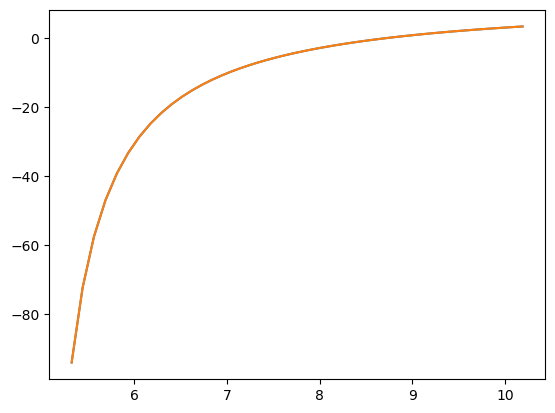

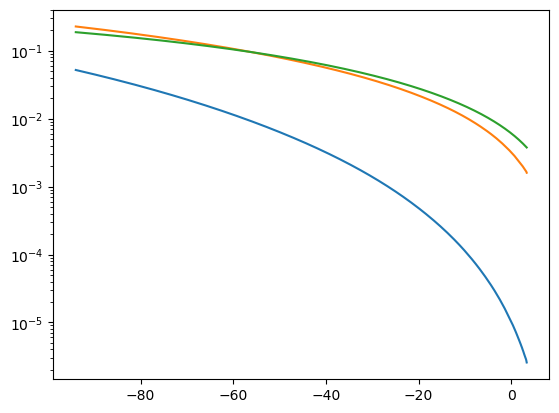

In [10]:
phi_ex_clist = np.linspace(np.pi*0.0,np.pi*0.415,85)
phi_ex_q1 = 0
phi_ex_q2 = 0.18*np.pi

index_q1 = 0
index_q2 = 2
index_c = 1

QCQ_geff = QCQ.Cal_geff(phi_ex_clist,
                        phi_ex_q1 = phi_ex_q1,
                        phi_ex_q2 = phi_ex_q2)
QCQ_eigens_list = QCQ_geff['QCQ_eigens_list']
g_xy_list = QCQ_geff['g_xy_list']
off_xy_index = QCQ_geff['off_xy_index']
omega01_lists = QCQ_geff['omega01_lists']
g_zz_list = QCQ_geff['g_zz_list']
leakage_cToq1_list = QCQ_geff['leakage_cToq1_list']
leakage_cToq2_list = QCQ_geff['leakage_cToq2_list']
omega01_off_list = omega01_lists[off_xy_index]  #关断点的01频率列表
omega01_q1_list,omega01_c_list,omega01_q2_list = list(map(list, zip(*omega01_lists))) #行列互换得到各自的频率列表

omega_q1sub_lists = [[omega - e['Eenergy_sub_list'][index_q1][0]
                     for omega in e['Eenergy_sub_list'][index_q1][1:]]
                    for e in QCQ_eigens_list]                                #无耦合的Q1频率列表
omega_csub_lists = [[omega - e['Eenergy_sub_list'][index_c][0]
                     for omega in e['Eenergy_sub_list'][index_c][1:]]
                    for e in QCQ_eigens_list]                                #无耦合的coupler频率列表
omega_q2sub_lists = [[omega - e['Eenergy_sub_list'][index_q2][0]
                     for omega in e['Eenergy_sub_list'][index_q2][1:]]
                    for e in QCQ_eigens_list]                                #无耦合的Q2频率列表

delta01_q1_list = [ o-omega01_off_list[index_q1] for o in omega01_q1_list]  #Q1频率与关断点的频率差
delta01_q2_list = [ o-omega01_off_list[index_q2] for o in omega01_q2_list]  #Q2频率与关断点的频率差
delta_qc1_list = [omega_c_sub[0]-omega_q1_sub[0] for omega_c_sub,omega_q1_sub 
                  in zip(omega_csub_lists,omega_q1sub_lists)]                 #比特1和coupler频率差
delta_qc2_list = [omega_c_sub[0]-omega_q2_sub[0] for omega_c_sub,omega_q2_sub 
                  in zip(omega_csub_lists,omega_q2sub_lists)]                 #比特1和coupler频率差

H_sys_lists = [QCQ.Coupling_H([phi_ex_q1,phi_c,phi_ex_q2])['H_total']
               for phi_c in phi_ex_clist]
psi1_tensor_lists = [eigen['psi1_tensor_list'] for eigen in QCQ_eigens_list]  #无耦合下的1态列表
psi1_lists = [eigen['psi1_list'] for eigen in QCQ_eigens_list]          #耦合系统下的1态列表
g_qq_list = [abs((psi_list[index_q1]*psi_list[index_q2].dag()*H).tr())
             for psi_list,H in zip(psi1_tensor_lists, H_sys_lists)]          #Q1Q2直接耦合强度
g_qc1_list = [abs((psi_list[index_q1]*psi_list[index_c].dag()*H).tr())
              for psi_list,H in zip(psi1_tensor_lists, H_sys_lists)]          #Q1-C直接耦合强度
g_qc2_list = [abs((psi_list[index_q2]*psi_list[index_c].dag()*H).tr())
              for psi_list,H in zip(psi1_tensor_lists, H_sys_lists)]          #Q2-C直接耦合强度

# 比特1 在关断点的频率和无耦合时的01频率差
Q1delta01_peak_off = omega01_off_list[index_q1] - omega_q1sub_lists[off_xy_index][0]
"""多项式拟合比特频率相对关断点的差值随coupler频率变化"""
params_delta = np.polyfit(omega01_c_list,np.log(-np.array(delta01_q1_list)-Q1delta01_peak_off),deg = 21)
Q1delta_fit = lambda o: -np.exp(np.poly1d(params_delta)(o)) - Q1delta01_peak_off

"""多项式拟合比特缀饰态|100>中含有coupler裸态|1>的概率随coupler频率变化"""
params_leakage = np.polyfit(omega01_c_list,np.log(np.array(leakage_cToq1_list)),deg = 21)
Q1leakage_fit = lambda o: np.exp(np.poly1d(params_leakage)(o))

plt.figure()
plt.plot([omega/2/np.pi for omega in omega01_c_list],
          [Q1delta_fit(omega)/2/np.pi/1e-3 for omega in omega01_c_list])
plt.plot([omega/2/np.pi for omega in omega01_c_list],
         [(omega)/2/np.pi/1e-3 for omega in delta01_q1_list])
# plt.plot([omega/2/np.pi for omega in omega01_c_list],
#           [(g**2/delta+g**2/(delta+2*fre_q1_sub_i[0]*2*np.pi))/2/np.pi/1e-3 for g,delta in zip(g_qc1_list,delta_qc1_list)])
# plt.plot([o_list[1]/2/np.pi for o_list in omega01_lists],
#           [g/1e-3/2/np.pi for g in g_xy_list],) 

omega01_c_range = np.linspace(np.min(omega01_c_list),np.max(omega01_c_list),1001)   #插值更多的频率
"""求解比特Q1频率相对coupler频率变化的导数"""
delta01_q1_range = Q1delta_fit(omega01_c_range)/2/np.pi/1e-3
patrial_Q1delta = [forward_diff(f = Q1delta_fit, x = omega)
                   for omega in omega01_c_range]              #导数的一次方
patrial_Q1delta_square = [p**2 for p in patrial_Q1delta]      #导数的平方

purcell_Q1leakage = Q1leakage_fit(omega01_c_range)            #由于态泄露引起的purcell效应


delta_exp_list = [-29,-39,-48,-56.7,-62.2,-71.2]
delta_index_list = [np.argmin(np.abs(delta01_q1_range-delta)) for delta in delta_exp_list]

"""计算coupler斜率"""
peak_eigens = QCQ.QCQ_eigens([0,0,0])
f01_peak_list = np.array(peak_eigens['omega01_list'])/2/np.pi    #顶点的f_01
f02_peak_list = np.array(peak_eigens['omega02_list'])/2/np.pi    #顶点的f_02
fah_peak_list = [f02-2*f01 for f01,f02 in zip(f01_peak_list,f02_peak_list)]  #顶点的非简谐
omega_c_need = [omega01_c_range[index] for index in delta_index_list]
k_phi_list = [flux_k_max_sim(f01_peak_list[index_c]*1e9, 
                             fah_peak_list[index_c]*1e9, 
                             omega_c*1e9/2/np.pi)[1]
              for omega_c in omega_c_need]   #coupler的磁通斜率 Hz/Phi_0


k_list = [patrial_Q1delta[index]*k_phi**2 
          for index,k_phi in zip(delta_index_list,k_phi_list)]
k_list = [k/k_list[2] for k in k_list]
k_square_list = [patrial_Q1delta_square[index]*k_phi**2 
                 for index,k_phi in zip(delta_index_list,k_phi_list)]
k_square_list = [k/k_square_list[2] for k in k_square_list]
k_purcell_list = [purcell_Q1leakage[index]*k_phi**2 
                  for index,k_phi in zip(delta_index_list,k_phi_list)]
k_purcell_list = [k/k_purcell_list[2] for k in k_purcell_list]

plt.figure()
plt.plot([(omega) for omega in delta01_q1_range],
          patrial_Q1delta_square,) 
# plt.plot([(omega) for omega in delta01_q1_range],
#           patrial_Q1delta,) 
plt.plot([(omega/2/np.pi/1e-3) for omega in delta01_q1_list],
          leakage_cToq1_list,)
# plt.plot(delta01_q1_range,
#          Q1leakage_fit(omega01_c_range)) 
# plt.plot([-omega/2/np.pi/1e-3 for omega in delta01_q1_list],
#           [g**2/delta**2 for g,delta in zip(g_qc1_list,delta_qc1_list)])

plt.yscale('log')

